In [1]:
import torch
import numpy as np
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from data_2d import generate_swastika, generate_spiral, generate_psi

In [2]:
def get_dataset(dataset_name:str='psi',  num_points_per_segment:int=1000, noise_std:float=0.02):
    if dataset_name == 'psi':
        sampled_points = generate_psi(num_points_per_segment=N, noise_std=nstd)
    
    if dataset_name == 'spiral':
        sampled_points = generate_spiral(num_points_per_segment=N, noise_std=nstd)
        
    if dataset_name == 'swastika':
        sampled_points = generate_swastika(num_points_per_segment=N, noise_std=nstd)
        
    else:
        sampled_points = generate_psi(num_points_per_segment=N, noise_std=nstd)
    return sampled_points

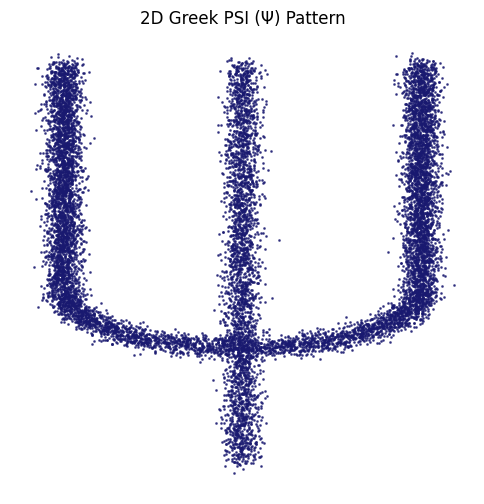

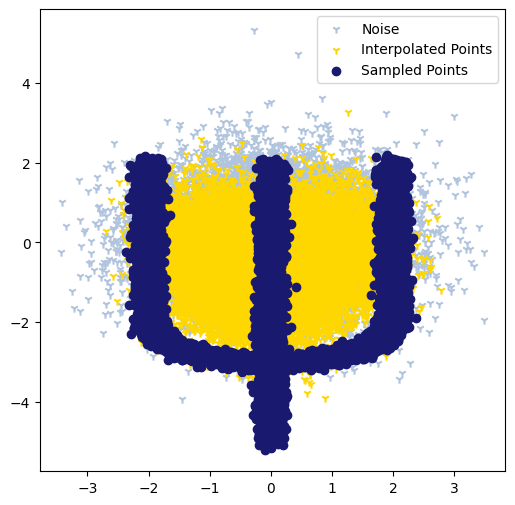

In [3]:
# Parameters
N = 3000  # Number of points per segment
nstd = 0.1 # Noise standard deviation

# Generate Ψ data points
sampled_points = get_dataset(dataset_name='phi', num_points_per_segment=N, noise_std=nstd)

# Visualize the Ψ pattern
plt.figure(figsize=(6, 6))
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], s=1, alpha=0.7, c='midnightblue')
plt.title("2D Greek PSI (Ψ) Pattern")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.axis("off")
plt.show()

# Linear interpolation between sampled_points and noise
t = 0.5
# Generate noise with the same shape as sampled_points
noise = np.random.randn(4 * N, 2)  # for spiral keep it at (N, 2), for swastika keep it at (6*N, 2)
plt.figure(figsize=(6, 6))
plt.scatter(noise[:, 0], noise[:, 1], color="lightsteelblue", marker="1", label="Noise")
interpolated_points = (1 - t) * noise + t * sampled_points.numpy()
plt.scatter(interpolated_points[:, 0], interpolated_points[:, 1], color="gold", marker="1", label="Interpolated Points")
plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="midnightblue", marker="o", label="Sampled Points")
plt.legend()
# plt.axis("off") # You can confirm the parameters 
plt.show()

data = torch.Tensor(sampled_points)

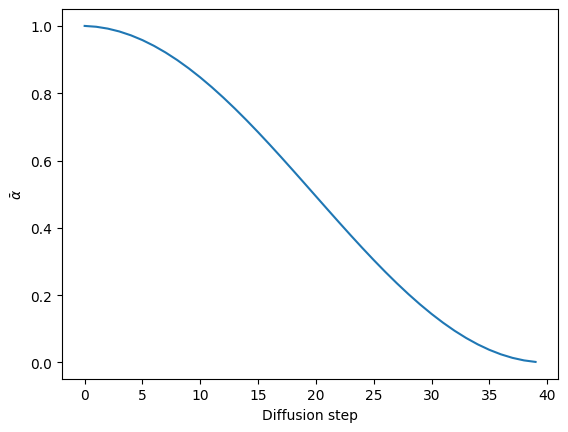

In [4]:
diffusion_steps = 40  # Number of steps in the diffusion process

s = 0.008
t = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((t / diffusion_steps + s) / (1 + s) * torch.pi / 2)**2

baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.concatenate([baralphas[0:1], baralphas[0:-1]])
alphas = 1 - betas

# Check the cumulative alphas follow the distribution recommended in the paper
sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

In [5]:
def noise(batch, t):
    eps = torch.randn(size=batch.shape)
    noised = (baralphas[t] ** 0.5).repeat(1, batch.shape[1]) * batch + ((1 - baralphas[t]) ** 0.5).repeat(1, batch.shape[1]) * eps
    return noised, eps

In [6]:
class DiffusionBlock(nn.Module):
    def __init__(self, nunits):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(nunits, nunits)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class MLP(nn.Module):
    def __init__(self, nfeatures: int, nblocks: int = 2, nunits: int = 64):
        super(MLP, self).__init__()

        self.inblock = nn.Linear(nfeatures+1, nunits)
        self.midblocks = nn.ModuleList([DiffusionBlock(nunits) for _ in range(nblocks)])
        self.outblock = nn.Linear(nunits, nfeatures)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        val = torch.hstack([x, t])  
        val = self.inblock(val)
        for midblock in self.midblocks:
            val = midblock(val)
        val = self.outblock(val)
        return val

In [7]:
model = MLP(nfeatures=2, nblocks=4)

# Check for CUDA, then MPS, otherwise fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")  # Use MPS for Apple Silicon
else:
    device = torch.device("cpu")  # Fallback to CPU

print(f'Using {device}')

model = model.to(device)

Using mps


In [8]:
nepochs = 10000
batch_size = 2048

loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=nepochs)
pbar = tqdm(range(nepochs))
for epoch in pbar:
    epoch_loss = steps = 0
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        t = torch.randint(0, diffusion_steps, size=[len(batch), 1])
        noised, eps = noise(batch, t)
        predicted_noise = model(noised.to(device), t.to(device))
        loss = loss_fn(predicted_noise, eps.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss
        steps += 1
        pbar.set_postfix(loss=f"{epoch_loss.item() / steps:.4f}")
    # print(f"Epoch {epoch} loss = {epoch_loss / steps}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [06:10<00:00, 26.98it/s, loss=0.5029]


In [9]:
def sample_ddpm(model, nsamples, nfeatures):
    """Sampler following the Denoising Diffusion Probabilistic Models method by Ho et al (Algorithm 2)"""
    with torch.no_grad():
        x = torch.randn(size=(nsamples, nfeatures)).to(device)
        xt = [x]
        for t in range(diffusion_steps-1, 0, -1):
            predicted_noise = model(x, torch.full([nsamples, 1], t).to(device))
            # See DDPM paper between equations 11 and 12
            x = 1 / (alphas[t] ** 0.5) * (x - (1 - alphas[t]) / ((1-baralphas[t]) ** 0.5) * predicted_noise)
            if t > 1:
                # See DDPM paper section 3.2.
                # Choosing the variance through beta_t is optimal for x_0 a normal distribution
                variance = betas[t]
                std = variance ** (0.5)
                x += std * torch.randn(size=(nsamples, nfeatures)).to(device)
            xt += [x]
        return x, xt

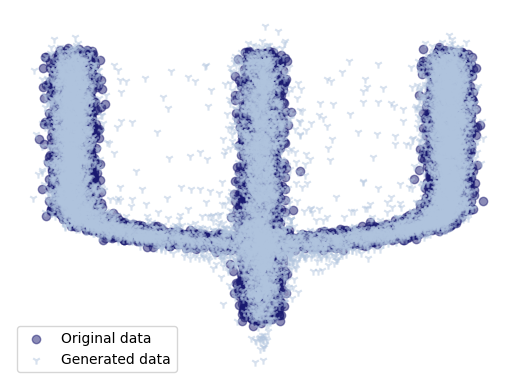

In [10]:
x, xt = sample_ddpm(model, 10000, 2)
x = x.cpu()

plt.scatter(data[:, 0], data[:, 1], color="midnightblue", alpha=0.5)
plt.scatter(x[:, 0], x[:, 1],color="lightsteelblue", marker="1", alpha=0.5)
plt.legend(["Original data", "Generated data"])
plt.axis("off")
plt.show()

In [11]:
import imageio
from pathlib import Path

# Create directory to save frames
frames_dir = Path("./ddpm_frames")
frames_dir.mkdir(exist_ok=True)

# Save plots for every i-th step
frames = []
step_interval = 1  
for i, step_data in enumerate(xt[::step_interval]):  # Slicing xt for every i-th step
    plt.figure(figsize=(6, 6))
    plt.scatter(data[:, 0], data[:, 1], color="midnightblue", alpha=0.5)
    plt.scatter(step_data.cpu().numpy()[:, 0], step_data.cpu().numpy()[:, 1], 
                color="lightsteelblue", marker="1", alpha=0.5)
    # plt.title(f"Step {i * step_interval}")
    plt.legend(["Original data", "Generated data"], bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.axis('off')
    frame_path = frames_dir / f"frame_{i:04d}.png"
    plt.savefig(frame_path)
    plt.close()
    frames.append(frame_path)

# Create the GIF
images = [imageio.imread(frame) for frame in frames]
gif_path = "ddpm_sampling.gif"
imageio.mimsave(gif_path, images, duration=0.1, loop=0)  # loop=0 for continuous loop

print(f"GIF saved at {gif_path}")


/var/folders/9c/n4gzrcgs55q8vvhd4jxcj2cc0000gn/T/ipykernel_5465/1933403589.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]


GIF saved at ddpm_sampling.gif


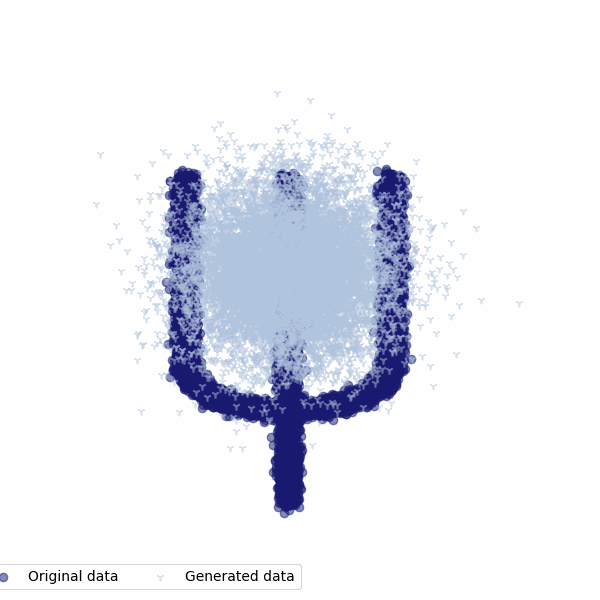

In [12]:
from IPython.display import Image, display, Markdown

# Read the video file
try:
    display(Image(data=open(gif_path,'rb').read(), format='png'))
except Exception as e:
    print(str(e))
    pass